<a href="https://colab.research.google.com/github/matteoalberti/Lectures_AdvCV_Experis2020/blob/main/day2/DL4CV_4_Architecture_Module_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://github.com/matteoalberti/Lectures_AdvCV_Experis2020/blob/main/day2/images/intro.jpg?raw=1)

# **Welcome!**

## Introduction to Machine Learning for Computer Vision



## **Lecturer :** Matteo Alberti

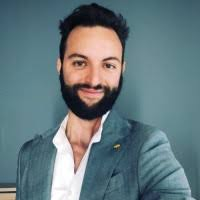

*Contacts :* https://www.linkedin.com/in/matteo-alberti-170493/


# Summary

- <font color=BE3315>**Introduction to Deep Models** </font> : Introduction to ResNet

  -  <font color=E15234>**State-of-the-Art** </font> : [Variants]  

  - <font color=E35F2A>**Transfer Learning & Pre-Trained Models** </font>

- <font color=F4C52D>**Exercises & Tips** </font>

## Start with Code: Step-by-Step

#### Load Packages

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import time

## Load Cifar10 data from Local File

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


##### Normalize data

In [ ]:
#The range for each individual colour is 0-255
x_train = x_train.astype('float32')/255 
x_test = x_test.astype('float32')/255

### Define HyperParameters & CNN Architecture
   

In [ ]:
#Parameters
import sys;import argparse; sys.argv=['']; del sys
parser = argparse.ArgumentParser(description="CNN")
parser.add_argument('--epochs', default=20, type=int)
parser.add_argument('--iter', default=100, type=int)
parser.add_argument('--batch_size', default=128, type=int)
parser.add_argument('--lr', default=0.001, type=float)

#For VGG
parser.add_argument('--weight_decay', default=0.0001, type=float)
parser.add_argument('--dropout', default=0.5, type=float)


parser.add_argument('--height', default=32, type=int)
parser.add_argument('--width', default=32, type=int)
parser.add_argument('--channel', default=3, type=int)
parser.add_argument('--classes', default=10, type=int)

#FOR RESNET
parser.add_argument('--stack_n', type=int, default=25, metavar='NUMBER',
                help='stack number n, total layers = 6 * n + 2 (default: 5)')

parser.add_argument('--train', default=False)
args = parser.parse_args()

layers_res = 6 * args.stack_n + 2
parser.add_argument('--layers_res', default=layers_res)

#Extras
parser.add_argument('--early_stop', default=3)


args = parser.parse_args()

print(args)

Namespace(batch_size=128, channel=3, classes=10, dropout=0.5, early_stop=3, epochs=20, height=32, iter=100, layers_res=152, lr=0.001, stack_n=25, train=False, weight_decay=0.0001, width=32)


# Thought Deep Convolutional Models

### Comparative study :
    
    Model	        n	200-epoch_accuracy	Original_paper_accuracy	   sec/epoch_on_GTX1080Ti
    ------------------------------------------------------------------------------------------
    ResNet20   v1	3	       92.16 %			91.25 %	   	         35     <-------------
    ResNet32   v1	5	       92.46 %			92.49 %					50
    ResNet44   v1	7	       92.50 %			92.83 %					70
    ResNet56   v1	9	       92.71 %			93.03 %					90
    ResNet110  v1	18	       92.65 %			93.39+-.16 %	     	165
    ResNet164  v1	27	         - %			94.07 %					 -
    ResNet1001 v1	N/A	        - %			92.39 %			 	    -
    ------------------------------------------------------------------------------------------

# Residual Neural Networks

### The easy way

In [ ]:
resnet50 = tf.keras.applications.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, classifier_activation='softmax')

resnet50.summary()

102973440/102967424 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
________________________

### Hard way!

#### First of all! 

*How can I re-write this?*


In [ ]:
#Instantiate an empty model

def build_VGG(input_shape, n_classes):
  return tf.keras.models.Sequential([    
  tf.keras.layers.Conv2D(64, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
  tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',),
  tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
  tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
  tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
  tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
  tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(4096, activation='relu'),
  tf.keras.layers.Dense(n_classes, activation='softmax')])

###VGG BLOCKS?

In [ ]:
#Instantiate an empty model

def VGG_blocks(n_conv, rec_field, act):
  return tf.keras.models.Sequential([    
  tf.keras.layers.Conv2D(n_conv, rec_field, padding='same', activation=act),
  tf.keras.layers.Conv2D(n_conv, rec_field, activation=act, padding='same'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))])

def CLASSIFICATION(n_dense, n_classes):
  return tf.keras.models.Sequential([
  tf.keras.layers.Dense(n_dense, activation='relu'),
  tf.keras.layers.Dense(n_dense, activation='relu'),
  tf.keras.layers.Dense(n_classes, activation='softmax')])

In [ ]:
inputs = tf.keras.Input(shape=(32,32,3))

x = VGG_blocks(n_conv=64, rec_field=(3,3), act='relu')(inputs)
x = VGG_blocks(n_conv=128, rec_field=(3,3), act='relu')(x)
x = VGG_blocks(n_conv=256, rec_field=(3,3), act='relu')(x)
x = tf.keras.layers.Flatten()(x)
outputs = CLASSIFICATION(n_dense=4096, n_classes=100)(x)


VGG_EASY = tf.keras.Model(inputs, outputs)
VGG_EASY.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential_11 (Sequential)   (None, 16, 16, 64)        38720     
_________________________________________________________________
sequential_12 (Sequential)   (None, 8, 8, 128)         221440    
_________________________________________________________________
sequential_13 (Sequential)   (None, 4, 4, 256)         885248    
_________________________________________________________________
flatten_3 (Flatten)          (None, 4096)              0         
_________________________________________________________________
sequential_14 (Sequential)   (None, 100)               33972324  
Total params: 35,117,732
Trainable params: 35,117,732
Non-trainable params: 0
__________________________________________

In [ ]:
# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)

n = 3
version = 1

if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

In [ ]:
# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version); print(model_type)

ResNet20v1


In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [ ]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
  
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """



### COMPLETE!

## Residual Neural Network [V1]

In [ ]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = tf.keras.layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])
            x = tf.keras.layers.Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = tf.keras.layers.AveragePooling2D(pool_size=8)(x)
    y = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model_v1 = resnet_v1(input_shape=(32,32,3), depth=depth)

In [ ]:
#Compile architecture
model_v1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_v1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
model_name = 'pretrained_model/cifar10_%s_model.{epoch:03d}.h5' % model_type

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='logs/checkpoint/',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [ ]:
# define callbacks

%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
model_v1.fit(x_train, y_train,
              batch_size=args.batch_size,
              epochs=50, validation_split=0.2,
              shuffle=True,
              callbacks=callbacks)

Learning rate:  0.001
Epoch 1/50
313/313 [==============================] - 31s 99ms/step - loss: 1.6790 - accuracy: 0.4550 - val_loss: 1.7163 - val_accuracy: 0.4477
Learning rate:  0.001
Epoch 2/50
313/313 [==============================] - 30s 96ms/step - loss: 1.2594 - accuracy: 0.6055 - val_loss: 1.4688 - val_accuracy: 0.5405
Learning rate:  0.001
Epoch 3/50
313/313 [==============================] - 30s 96ms/step - loss: 1.0711 - accuracy: 0.6703 - val_loss: 1.3455 - val_accuracy: 0.6006
Learning rate:  0.001
Epoch 4/50
313/313 [==============================] - 30s 96ms/step - loss: 0.9437 - accuracy: 0.7185 - val_loss: 1.4298 - val_accuracy: 0.6062
Learning rate:  0.001
Epoch 5/50
313/313 [==============================] - 30s 96ms/step - loss: 0.8434 - accuracy: 0.7550 - val_loss: 1.0908 - val_accuracy: 0.6821
Learning rate:  0.001
Epoch 6/50
313/313 [==============================] - 30s 96ms/step - loss: 0.7566 - accuracy: 0.7852 - val_loss: 1.2963 - val_accuracy: 0.6303
Lear

In [ ]:
# Score trained model.
scores = model_v1.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

313/313 [==============================] - 3s 11ms/step - loss: 2.0879 - accuracy: 0.6692
Test loss: 2.087925672531128
Test accuracy: 0.6692000031471252


In [ ]:
%tensorboard --logdir logs/fit

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

# Predict the labels of the test set samples
predicted_labels = model_v1.predict(x_test)

# Build the confusion matrix of our 10-class classification problem
cnf_matrix = confusion_matrix(y_test, predicted_labels)

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

disp = plot_confusion_matrix(model_v1, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
plt.show()

## Variants?

###### ResNetV2
- Main difference : Batch normalization before each weight layer

###### ResNext
- different identity mappings building block
    - different paths of stacked identity layers
    - new hyperparameter "cardinality" for paths number

## Residual Neural Network [V2]

In [ ]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = tf.keras.Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(3):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = tf.keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.AveragePooling2D(pool_size=8)(x)
    y = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

Paper 1 : [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

Paper 2 : [Dentity mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)

Paper 3 : [Aggregated Residual Transformation for Deep Neural Networks ](https://arxiv.org/pdf/1611.05431.pdf)

Paper 4 : [Residual Networks Behave Like Ensembles of
Relatively Shallow Networks
](https://arxiv.org/pdf/1605.06431.pdf)

Real-world application to Transfer Learning

## Why Learning Residual Neural Networks is so useful?

    Because : 

    Poor Response:
        1) State-of-the-art
        2) We have many pre-trained models

    Good Response:
        3) Object Detection & Semantic Segmentation
        4) Residual Learning is not just for computer vision

###### 3) "Object Detection" -  "Semantic Segmentation"

<img src="https://storage.googleapis.com/groundai-web-prod/media%2Fusers%2Fuser_14%2Fproject_203625%2Fimages%2Fpaper_fig1.png" width="800">

# Best Practices

### Networks comparison


![](https://drive.google.com/uc?export=view&id=1UAMFe0DVD01waU-v0JcqEijWdNA6EBPX)

## How can I managed and use other pre-trained models?

*Check tensorflow hub :* https://www.tensorflow.org/hub

*You'll find lots of models... also of NLP domain...*

# [Interactive Session]

*Here you'll find some extra exercises, just ignore them if you want. The main idea of these extra exercises is to make you focus on other possible aspects of ML models and implementations*

#### Question 1) 

    Check requirements of tf.keras.applications.ResNet50

In [ ]:
tf.keras.applications.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=(32,32,3),
    pooling=None, classes=1000, classifier_activation='softmax')

ValueError: ignored

    Why this error? What can I do?

#### Exercise 1) 

    What happens to our networks's parameteres number if we convert our data from RGB to B/N? (*Tips : use openCV or numpy functions*)

    Check also :

    - Time to execution of our training?
    - Accuracy?
    

### Try yourself before!

#### Solution

In [ ]:
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r, g, b = np.asarray(.3, dtype=dtype), np.asarray(.59, dtype=dtype), np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

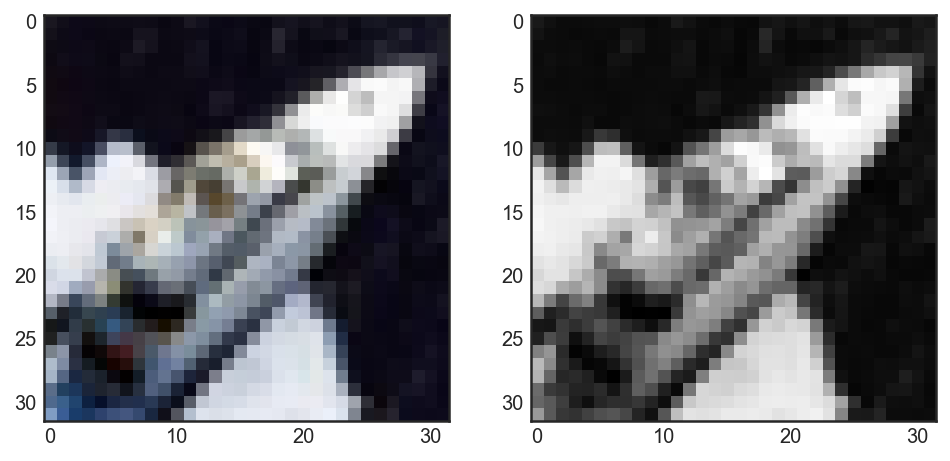

(7000, 32, 32, 1) (7000, 10) (1000, 32, 32, 1) (1000, 10)


In [ ]:
x_train_gray = grayscale(x_train)
x_test_gray = grayscale(x_test)
x_val_gray = grayscale(x_val)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(x_train[0], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(x_train_gray[0, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

print(x_train_gray.shape,y_train.shape, x_test_gray.shape,y_test.shape )

#### Exercise 2-3) 

    - What is the gain in the number of parameters for VGG Net / ResNet?
    - Calculate the difference in terms of time

### Try yourself before!

### Solution!

In [ ]:
lenet_base.count_params()

62006

In [ ]:
VGG_Net_rgb = VGG19(height=args.height, width=args.width, 
                channel=args.channel,classes=args.classes,
                weight_decay=args.weight_decay, dropout=args.dropout,
                pretrained_path='', summ=False)

VGG_Net_bn = VGG19(height=args.height, width=args.width, 
                channel=1,classes=args.classes,
                weight_decay=args.weight_decay, dropout=args.dropout,
                pretrained_path='', summ=False)


resnet_model_rgb = resnet_v1(input_shape=(args.height,args.width,args.channel),
                         depth=args.layers_res, num_classes=args.classes,
                        pretrained_path='',
                        summ=False)

resnet_model_bn = resnet_v1(input_shape=(args.height,args.width,args.channel),
                         depth=args.layers_res, num_classes=1,
                        pretrained_path='',
                        summ=False)

###########################################################################

print('Difference for VGG : ', round((VGG_Net_rgb.count_params() - VGG_Net_bn.count_params())
                                    /( VGG_Net_rgb.count_params())*100, 2))

print('Difference for ResNet : ', round((resnet_model_rgb.count_params() - resnet_model_bn.count_params())
                                    /( resnet_model_rgb.count_params())*100, 2))

Difference for VGG :  0.0
Difference for ResNet :  0.02


##### Evaluate fit time

In [ ]:
# build network for RGB
lenet_base_rgb = build_Lenet(height=args.height, width=args.width, channel=args.channel, classes=args.classes)
# build network for BN
lenet_base_bn = build_Lenet(height=args.height, width=args.width, channel=1, classes=args.classes)

In [ ]:
class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [ ]:
# set callback
tb_cb = TensorBoard(log_dir='./logs', histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
time_callback = TimeHistory()

cbks = [change_lr,tb_cb, time_callback]

In [ ]:
# start train
history_lenet_rgb = lenet_base_rgb.fit(x_train, y_train,
          batch_size=args.batch_size,
          epochs=1,
          callbacks=cbks,
          validation_data=(x_val, y_val),
          shuffle=True, verbose=1)

Train on 7000 samples, validate on 2000 samples
Epoch 1/1
7000/7000 [==============================] - ETA: 11s - loss: 2.0879 - acc: 0.25 - ETA: 11s - loss: 2.0821 - acc: 0.23 - ETA: 11s - loss: 2.0888 - acc: 0.23 - ETA: 11s - loss: 2.0989 - acc: 0.23 - ETA: 11s - loss: 2.0816 - acc: 0.24 - ETA: 10s - loss: 2.0720 - acc: 0.26 - ETA: 10s - loss: 2.0594 - acc: 0.26 - ETA: 10s - loss: 2.0518 - acc: 0.26 - ETA: 10s - loss: 2.0474 - acc: 0.27 - ETA: 10s - loss: 2.0499 - acc: 0.27 - ETA: 10s - loss: 2.0463 - acc: 0.28 - ETA: 9s - loss: 2.0472 - acc: 0.2773 - ETA: 9s - loss: 2.0687 - acc: 0.270 - ETA: 9s - loss: 2.1134 - acc: 0.260 - ETA: 9s - loss: 2.1079 - acc: 0.262 - ETA: 9s - loss: 2.1033 - acc: 0.262 - ETA: 8s - loss: 2.1017 - acc: 0.258 - ETA: 8s - loss: 2.0981 - acc: 0.256 - ETA: 8s - loss: 2.0947 - acc: 0.257 - ETA: 8s - loss: 2.0905 - acc: 0.260 - ETA: 7s - loss: 2.0849 - acc: 0.262 - ETA: 7s - loss: 2.0802 - acc: 0.264 - ETA: 7s - loss: 2.0748 - acc: 0.264 - ETA: 7s - loss: 2.0706

In [ ]:
times_rgb = time_callback.times; times_rgb

[14.679846286773682]

In [ ]:
# start train
history_lenet_rgb = lenet_base_bn.fit(x_train_gray, y_train,
          batch_size=args.batch_size,
          epochs=1,
          callbacks=cbks,
          validation_data=(x_val_gray, y_val),
          shuffle=True, verbose=1)

Train on 7000 samples, validate on 2000 samples
Epoch 1/1
7000/7000 [==============================] - ETA: 12s - loss: 2.3882 - acc: 0.08 - ETA: 10s - loss: 2.3836 - acc: 0.08 - ETA: 9s - loss: 2.3805 - acc: 0.0938 - ETA: 8s - loss: 2.3747 - acc: 0.095 - ETA: 8s - loss: 2.3644 - acc: 0.101 - ETA: 8s - loss: 2.3618 - acc: 0.093 - ETA: 7s - loss: 2.3533 - acc: 0.099 - ETA: 7s - loss: 2.3479 - acc: 0.102 - ETA: 7s - loss: 2.3435 - acc: 0.103 - ETA: 6s - loss: 2.3391 - acc: 0.106 - ETA: 6s - loss: 2.3360 - acc: 0.105 - ETA: 6s - loss: 2.3341 - acc: 0.102 - ETA: 6s - loss: 2.3312 - acc: 0.102 - ETA: 6s - loss: 2.3286 - acc: 0.101 - ETA: 6s - loss: 2.3276 - acc: 0.101 - ETA: 5s - loss: 2.3262 - acc: 0.100 - ETA: 5s - loss: 2.3240 - acc: 0.102 - ETA: 5s - loss: 2.3228 - acc: 0.103 - ETA: 5s - loss: 2.3209 - acc: 0.102 - ETA: 5s - loss: 2.3201 - acc: 0.102 - ETA: 5s - loss: 2.3196 - acc: 0.103 - ETA: 5s - loss: 2.3180 - acc: 0.106 - ETA: 4s - loss: 2.3167 - acc: 0.108 - ETA: 4s - loss: 2.3149

In [ ]:
times_bn = time_callback.times; times_bn

[9.374999046325684]

In [ ]:
print('\n Difference of time for 1 epochs : ', round((times_rgb[0] - times_bn[0])
                                    /( times_rgb[0])*100, 2), '%')

print('\n Difference for real training of 200 epochs :', (times_rgb[0]*200 - times_bn[0]*200)/60)


 Difference of time for 1 epochs :  36.14 %

 Difference for real training of 200 epochs : 17.68282413482666


## Tranfer Learning with ResNet on Cifar100!!!!

In [ ]:
# Load ResNet50 with imagenet weights!!

In [ ]:
# Load Cifar100

In [ ]:
# Lets adapt Cifar100 to ResNet!

# tips!
model = Sequential()
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(UpSampling2D())
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.25))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
# Set up as not trainable Batch Layers!!


# Why???? : This is because the BN layer would be using statistics of training data, instead of one used for inference. Only if :
# ...if the target dataset on which model is being trained on is different from the originally used training dataset



In [ ]:
# TRAIN!

# How many epochs? 20 should be fine!!!!